# MATH50003 (2023–24)
# Revision Lab

In [2]:
using LinearAlgebra, SetRounding, Test, Plots

**Problem 1(a)** Simpson's rule on a single panel is given by
$$
∫_a^b f(x) {\rm d}x ≈ {b-a \over 6} \left[f(a) + 4 f\!\left({a+b \over 2}\right) + f(b) \right].
$$
Complete the implementation of `simpsonsrule` by dividing $[0,1]$ into grid points $x_0, x_1, …, x_{2n}$ with $x_k = k/(2n)$
and applying Simpson's rule on the intervals $[x_{2k-2},x_{2k}]$ for $k = 1,…,n$.

In [3]:
function simpsonsrule(f, n)
    # TODO: implement Simpsons rule
    h = 1/n
    res = 0

    for k = 1:n
        x_k = k/n
        x_k2 = (k-1)/n
        res += (f(x_k2) + 4*f((x_k+x_k2)/2) + f(x_k))
    end

    (h / 6) * res
end

@test simpsonsrule(exp, 1000) ≈ exp(1)-1

Test Passed

**Problem 1(b)** By computing with various values of $n$, conjecture what the convergence rate is as $n → ∞$. Is it faster than Trapezium rules $O(n^{-2})$?

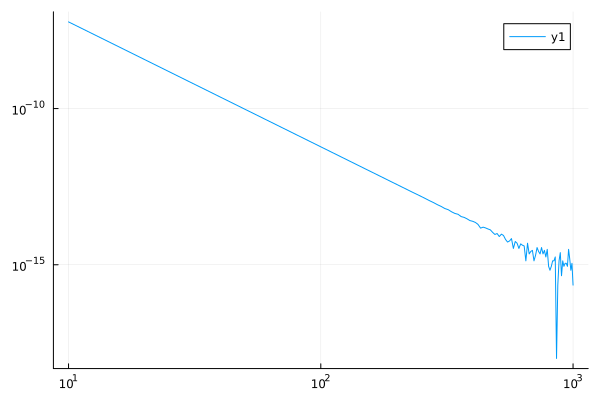

In [28]:
# TODO: vary n and deduce the converge rate, either by looking at errors or by plotting
n = 10 .* (1:100)

errs = abs.(simpsonsrule.(exp, n) .- (exp(1)-1)) .+ 1e-18
plot(n, errs, yscale=:log10, xscale=:log10) # seems about O(n^-4)


**Problem 2** Consider a 3-term divided-difference approximation
$$
f'(x) ≈ {5f(x+2h) - 3f(x) - 2f(x-h) \over 12h}
$$
Implement this in the following function.

In [5]:
function threeterm_divideddifference(f, x, h)
    (5*f(x+2*h) - 3*f(x) - 2*f(x-h)) / (12*h)

end
@test threeterm_divideddifference(exp, 0, 0.0000001) ≈ 1 atol=1E-5

Test Passed

**Problem 3** Using the following simplified `Dual` implementation, consider a double-dual number
like `Dual(Dual(a,b), Dual(c,d))`. By choosing `a`, `b`, `c` and `d`, construct the function `secondderivative(f, x)`
that computes the second derivative of a function. Hint: it might help to think of a double-dual number as
$(a + b*ε) + δ*(c + d*ε)$ where $ε^2 = δ^2 = 0$.

In [6]:
struct Dual
    a
    b
end

import Base: +, *, exp
function +(x::Dual, y::Dual)
    a,b = x.a, x.b # x == a+bϵ. This gets out a and b
    c,d = y.a, y.b # y == c+dϵ. This gets out c and d
    Dual(a+c, b+d)
end
function *(x::Dual, y::Dual)
    a,b = x.a, x.b # x == a+bϵ. This gets out a and b
    c,d = y.a, y.b # y == c+dϵ. This gets out c and d
    Dual(a*c, b*c + a*d)
end
exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)


function secondderivative(f, x)
    # TODO: compute the second derivative of f using a double-dual number
    f(Dual(Dual(x, 1), Dual(1, 0))).b.b
end

f = x -> exp(x*exp(x))
@test secondderivative(f, 0) ≈ 3

Test Passed

**Problem 4** Implement the following function
`primedigits` that constructs a positive `Float64` of the form $2^q * (1.b_1…b_S)$
where the exponent is specified by `q` and has significand
bits
$$
b_k = \begin{cases}
    1 & k\hbox{ is prime} \\
    0 & \hbox{otherwise}
    \end{cases}
$$
Hint: use the `gcd` function to determine if a number is prime.

In [11]:
function primedigits(q)
    # TODO: return a Float64 with the specified bits.
    r = Float64(1) 

    for k=2:52
        if isprime_t(k)
            r += (Float64(2)^(-k))
        end
    end

    r * 2^q
end

function isprime_t(n)
    n = Int(floor(n))  
    for k = 2:floor(sqrt(n))
        if n % k == 0
            return false
        end
    end
    return true
end



@test primedigits(3) == 11.317460078808892

Test Passed

**Problem 5** Implement the `sqrt` function with correctly rounded interval arithmetic.

In [ ]:
struct Interval # represents the set [a,b]
    a # left endpoint
    b # right endpoint
end

Interval(x) = Interval(x,x) # Support Interval(1) to represent [1,1]

import Base: sqrt, in
in(x, X::Interval) = X.a ≤ x ≤ X.b

function sqrt(X::Interval)
    a,b = promote(X.a, X.b) # make sure all are the same type
    T = typeof(a)
    # TODO: implement sqrt by correctly rounding the computation.
    α = setrounding(T, RoundDown) do 
        sqrt(a)
    end
    

    β = setrounding(T, RoundUp) do 
        sqrt(b)
    end

    Interval(α, β)
end

@test sqrt(big(2.0)) in sqrt(Interval(2.0))

Test Passed

**Problem 6(a)**  Consider the Schrödinger equation with quadratic oscillator:
$$
u(-L) = u(L) = 0, -u'' + x^2 u = f(x)
$$
Use row-eliminations to recast the tridiagonal finite-difference discretisation as a symmetric tridiagonal
system, solved via the `SymTridiagonal` type,.

In [29]:
function schrodingersolve(n, L, f)
    x = range(-L,L;length=n+1) # discretisation grid
    h = (2*L)/n
    # TODO: Implement finite differences using a SymTridiagonal matrix, by using the knowledge of the solution at ±L.
    A = SymTridiagonal([1; 2/(h^2) .+ (x[2:end-1] .^ 2); 1], [fill(-1/(h^2), n-1); 0])
    fs = f.(x)
    A \ fs
end

f = x-> 2exp(-x^2) - 3exp(-x^2)*x^2
n,L = 10000,10
x = range(-L,L;length=n+1)
@test schrodingersolve(n, L, f) ≈ exp.(-x.^2) atol=1E-4

Test Passed

**Problem 6(b)** The `eigvals` function computes eigenvalues of a matrix. Use this alongside the
symmetric diagonal discretisation to approximate $λ$ such that
$$
u(-L) = u(L) = 0, -u'' + x^2 u = λ u
$$
has a non-zero solution (i.e., an eigenvalue of the differential equation).
Can you conjecture their exact value if $L → ∞$?

In [43]:
function shrodingereigvals(n, L)
    x = range(-L,L;length=n+1) # discretisation grid
    # TODO: Use eigvals with a SymTridiagonal discretisation to approximate the eigenvalues of a Schrödinger operator
    h = (2*L)/n
    A = SymTridiagonal([1; 2/(h^2) .+ (x[2:end-1] .^ 2); 1], [fill(-1/(h^2), n-1); 0])
    eigvals(A)
end

# TODO: add experiments and a comment where you conjecture the true eigenvalues.
shrodingereigvals(10_000, 100) # eigenvalues are 2k + 1 for k ∈ 𝐍

10001-element Vector{Float64}:
  -415.8087696990055
     0.9999749994599447
     1.0
     2.9998749943858094
     4.999674978091564
     6.999374943112224
     8.998974881885514
    10.998474786702214
    12.997874650459181
    14.997174465380942
    16.996374223937522
    18.995473918715376
    20.99447354227129
     ⋮
 19693.333397637245
 19693.891839468
 19729.790288941047
 19730.350288390975
 19768.974991311916
 19769.536663095503
 19811.912244534942
 19812.475746636243
 19860.584906672644
 19861.150480849992
 19920.165669523638
 19920.733776226618

**Problem 7** Implement `reversecholesky(A)` that returns an upper-triangular matrix `U` such that `U*U' ≈ A`.
You may assume the input is symmetric positive definite and has `Float64` values. You must not use the inbuilt `cholesky`
function or in any other way reduce the problem to a standard Cholesky factorisation.

In [44]:
function reversecholesky(A)
    n,m = size(A)
    if n ≠ m
        error("Matrix must be square")
    end
    if A ≠ A'
        error("Matrix must be symmetric")
    end
    U = UpperTriangular(zeros(n,n))
    # TODO: populate U so that U'U ≈ A

    Aⱼ = copy(A)
    for j = n:-1:1
        α,𝐯 = Aⱼ[j,j],Aⱼ[j,1:j-1]

        U[j,j] = sqrt(α)
        U[1:j-1,j] = 𝐯/sqrt(α)

        # induction part
        K = Aⱼ[1:j-1, 1:j-1] # drop first row and column of A
        Aⱼ = K - 𝐯*𝐯'/α
    end

    U
end

A = [2 1 0; 1 2 1; 0 1 2]
U = reversecholesky(A)
@test U*U' ≈ A

Test Passed

**Problem 8** Complete the function `lagrangebasis(g, k, x)` where `g` is a vector of grid
points, that computes the Lagrange basis function at the point `x`. You may assume all numbers
are `Float64`.

In [ ]:
function lagrangebasis(g::AbstractVector, k, x)
    n = length(g) # number of points
    ## TODO: compute ℓ_k(x) corresponding to the grid g
    prod = 1

    for m=1:length(g) 
        if m != k 
            prod *= (x-g[m])/(g[k]-g[m])
        end
    end
    prod
end

g = 1:5
@test lagrangebasis(g, 2, 2) == 1
@test lagrangebasis(g, 2, 3) == lagrangebasis(g, 2, 4) ==  0
@test lagrangebasis(g, 3, 0.1) ≈ 8.169525

Test Passed

**Problem 9(a)**  Construct a reverse Householder reflection, that gives an orthogonal matrix
$Q$ such that, for $𝐱 ∈ ℝ^n$,
$$
𝐱^⊤ Q = \|𝐱\|𝐞_1^⊤.
$$

In [49]:
function reversehouseholderreflection(x)
    # TODO: implement a Householder reflection that acts on the left
    y = copy(x)
    y[1] -= norm(y)
    w = y / norm(y)
    I - 2*w*w'
end

x = randn(5)
Q = reversehouseholderreflection(x)
@test x'Q ≈ [norm(x) zeros(1,4)]

Test Passed

**Problem 9(b)**
Complete the function `lq(A)` that
returns a LQ factorisation, that is, `A = LQ` where  `L` is lower triangular and `Q` is an orthogonal
matrix. You may assume that `A` is a square `Matrix{Float64}`.  Do not manipulate the problem
to reduce it to a standard QR factorisation.

In [60]:
function lq_t(A)
    m,n = size(A)
    m == n || error("not square")
    # TODO Create Q and L such that A = L*Q, Q'Q == I and L is lower triangular
    L = copy(A)
    Q = Matrix(1.0I, n, n)
    for k = 1:n-1
        Qₖ =  reversehouseholderreflection(L[k, k:end])
        L[k:end, k:end] = L[k:end, k:end] * Qₖ
        Q[k:end, :] = Qₖ * Q[k:end, :]
    end
    L,Q
end

A = [1.0 2 3; 1 4 9; 1 1 1]
L,Q = lq_t(A)
@test Q'Q ≈ I
@test L*Q ≈ A
@test L ≈ tril(L) # it is acceptable to have small non-zero entries in L

Test Passed

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*